## Notebook to combine the demultiplexed GEX per pool per lane anndata objects into a single anndata

this is just to combine them not correct, see combat (old/simple), MNN, and BBKNN for that

In [1]:
!date

Wed Aug 30 15:02:57 EDT 2023


#### import libraries and set notebook variables

In [2]:
from pandas import read_csv
from scanpy import read_h5ad
from os.path import exists
from anndata import concat as ad_concat
from seaborn import barplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
# naming
project = 'aging_phase2'
modality = 'GEX'
set_name = f'{project}_{modality}'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
demux_dir = f'{wrk_dir}/demux'
info_dir = f'{wrk_dir}/sample_info'
quants_dir = f'{wrk_dir}/quants'

# in files
info_file = f'{info_dir}/{project}.sample_info.csv'

# out files
output_file = f'{quants_dir}/{set_name}.raw.h5ad'

# variables
DEBUG = False
lane_range = range(1, 9)

### load the sample info data

In [4]:
info_df = read_csv(info_file)
print(f'shape of info {info_df.shape}')
info_df = info_df.loc[(~info_df.gex_pool.isna()) & (~info_df.atac_pool.isna())]
print(f'shape of info {info_df.shape}')
# make sure pool nums are ints and not floats
info_df.gex_pool = info_df.gex_pool.astype('int')
info_df.atac_pool = info_df.atac_pool.astype('int')
print(f'shape of info {info_df.shape}')
if DEBUG:
    display(info_df.head())
    display(info_df.gex_pool.value_counts())

shape of info (36, 13)
shape of info (33, 13)
shape of info (33, 13)


#### combine the individual anndatas into single large anndata

In [5]:
%%time
adata_list = []

pools = set(info_df.gex_pool.unique()) | set(info_df.atac_pool.unique())

for pool in pools:
    for lane in lane_range:
        gex_pool = f'{demux_dir}/{modality}_P{pool}_{lane}.h5ad'
        if exists(gex_pool):
            this_adata = read_h5ad(gex_pool)
            if DEBUG:
                print(f'{modality}_P{pool}_{lane}: {this_adata}')
            adata_list.append(this_adata)

all_adata = ad_concat(adata_list)
all_adata.obs_names_make_unique()

CPU times: user 3.53 s, sys: 1.85 s, total: 5.38 s
Wall time: 7.47 s


/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
print(all_adata)
if DEBUG:
    display(all_adata.obs.sample(10))

AnnData object with n_obs × n_vars = 140187 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id'


#### save the combined anndata object

In [7]:
all_adata.write(output_file)

#### visualization functions

In [8]:
# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='sample_id'):
    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-talk')    
        barplot(x=this_df[id_col].value_counts().index, 
                y=this_df[id_col].value_counts().values, 
                order=this_df[id_col].value_counts().index,
                palette='Blues_d')
        plt.xticks(rotation=90, fontsize=8)
        plt.tight_layout()
        plt.title(sample_name)
        plt.ylabel('barcode counts')
        plt.show()
    print(this_df[id_col].value_counts())        

#### visualize the counts by sample

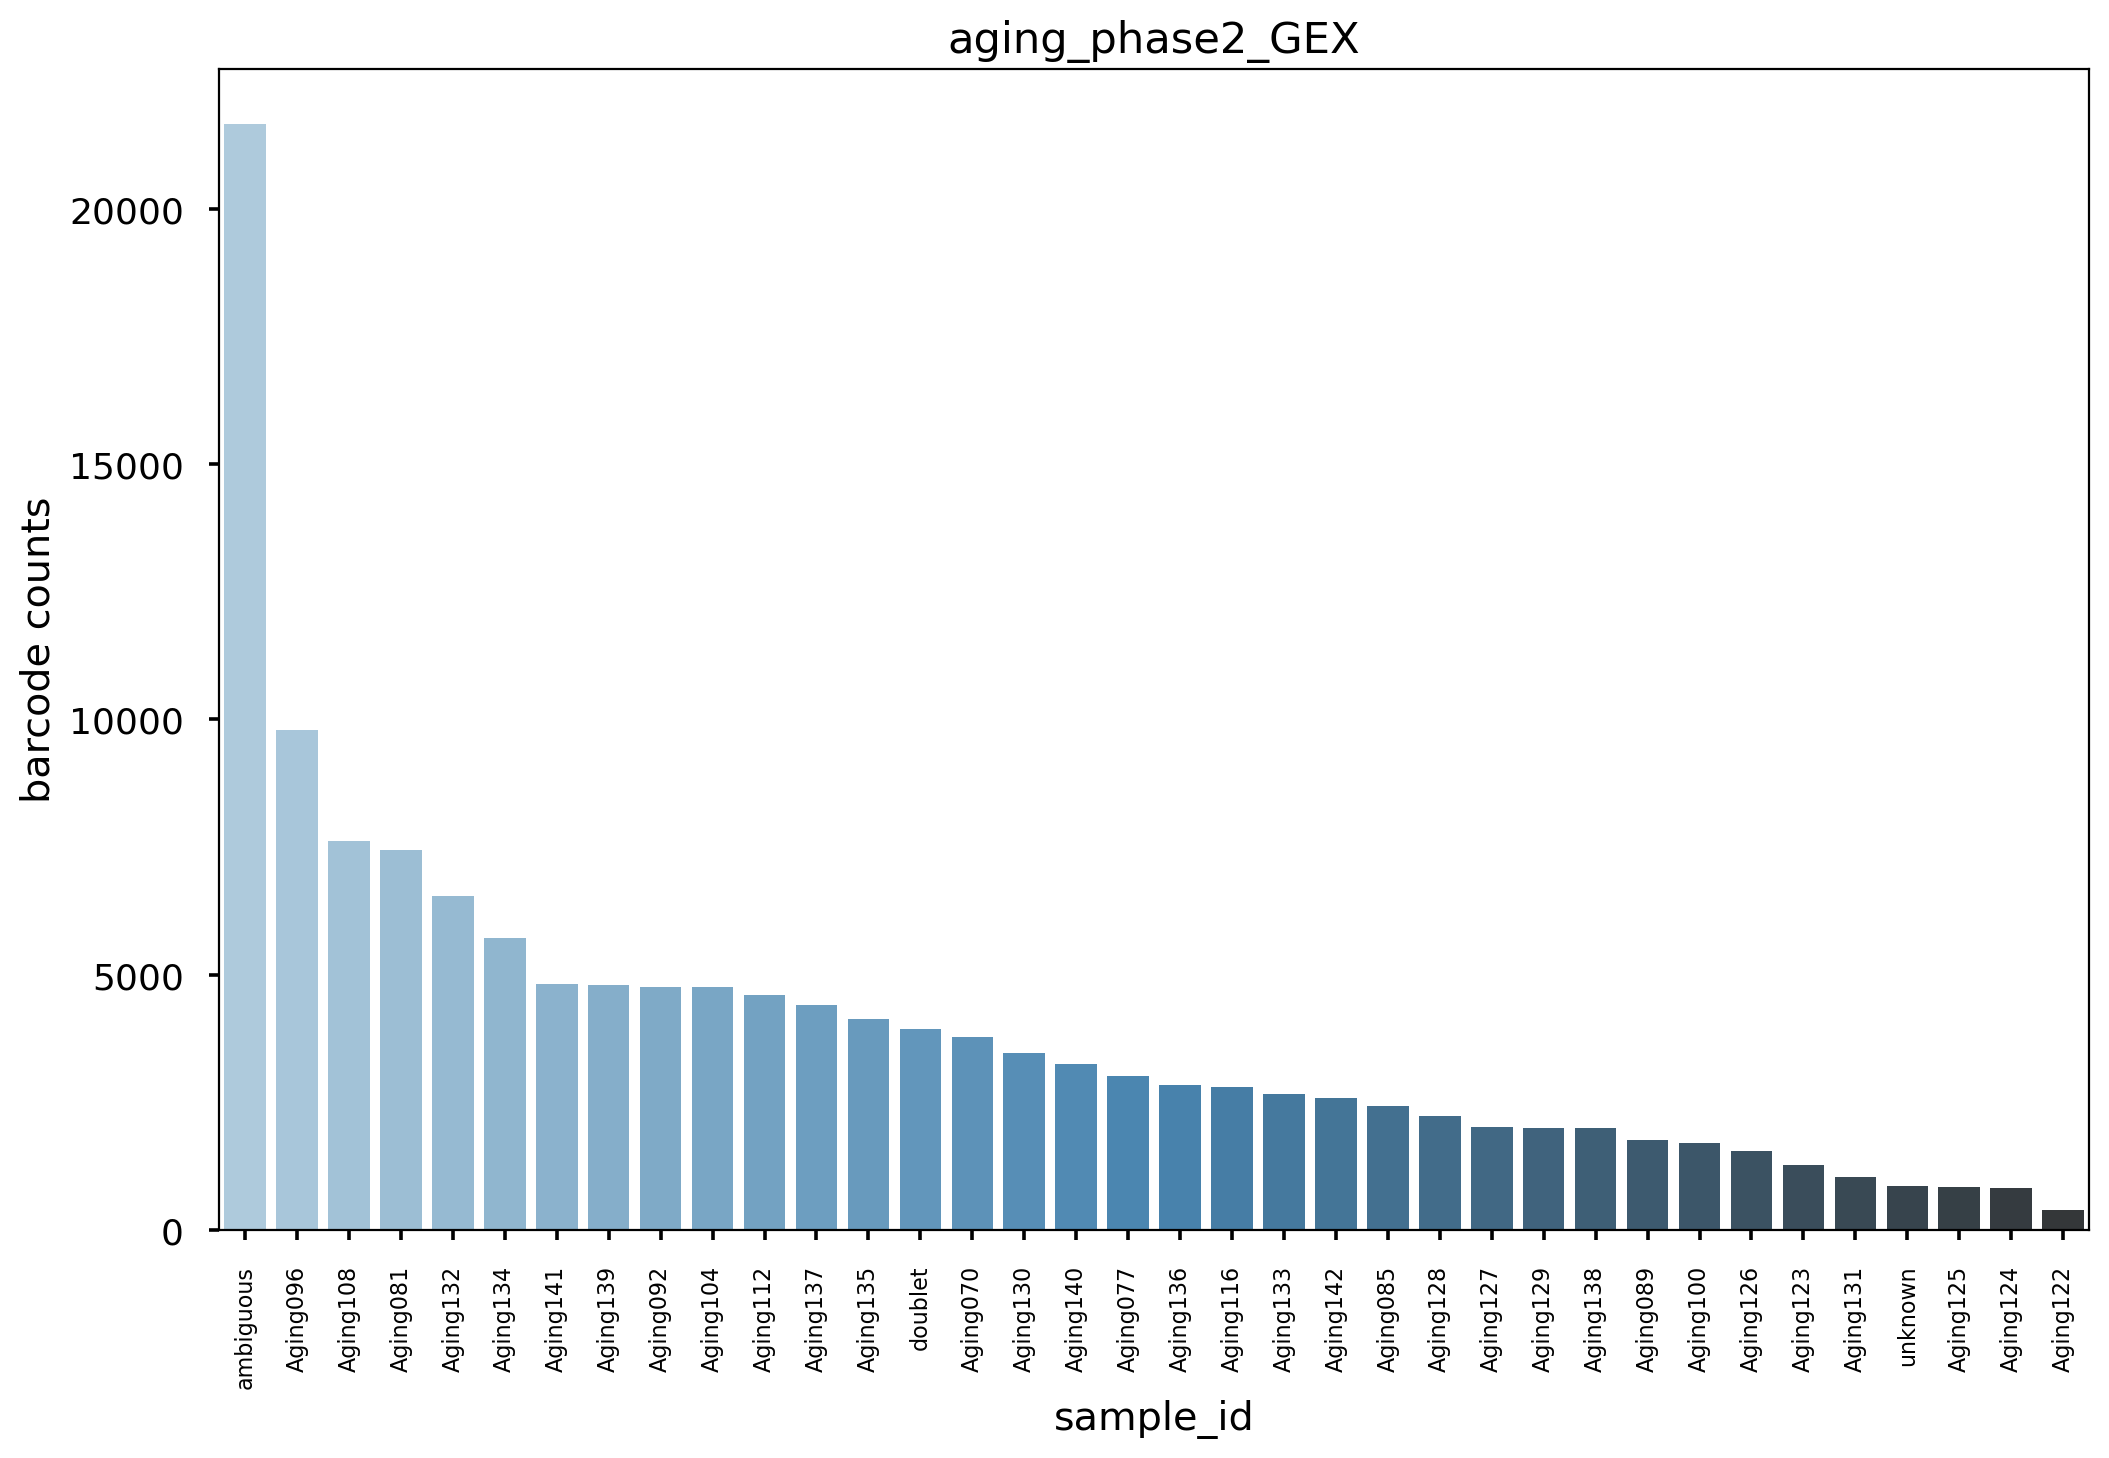

sample_id
ambiguous    21658
Aging096      9785
Aging108      7626
Aging081      7445
Aging132      6544
Aging134      5709
Aging141      4821
Aging139      4796
Aging092      4759
Aging104      4750
Aging112      4596
Aging137      4412
Aging135      4123
doublet       3929
Aging070      3776
Aging130      3460
Aging140      3253
Aging077      3016
Aging136      2844
Aging116      2792
Aging133      2654
Aging142      2585
Aging085      2419
Aging128      2239
Aging127      2011
Aging129      2000
Aging138      1995
Aging089      1756
Aging100      1697
Aging126      1540
Aging123      1270
Aging131      1032
unknown        860
Aging125       834
Aging124       816
Aging122       385
Name: count, dtype: int64


In [9]:
plot_sample_barcode_counts(all_adata.obs, set_name)

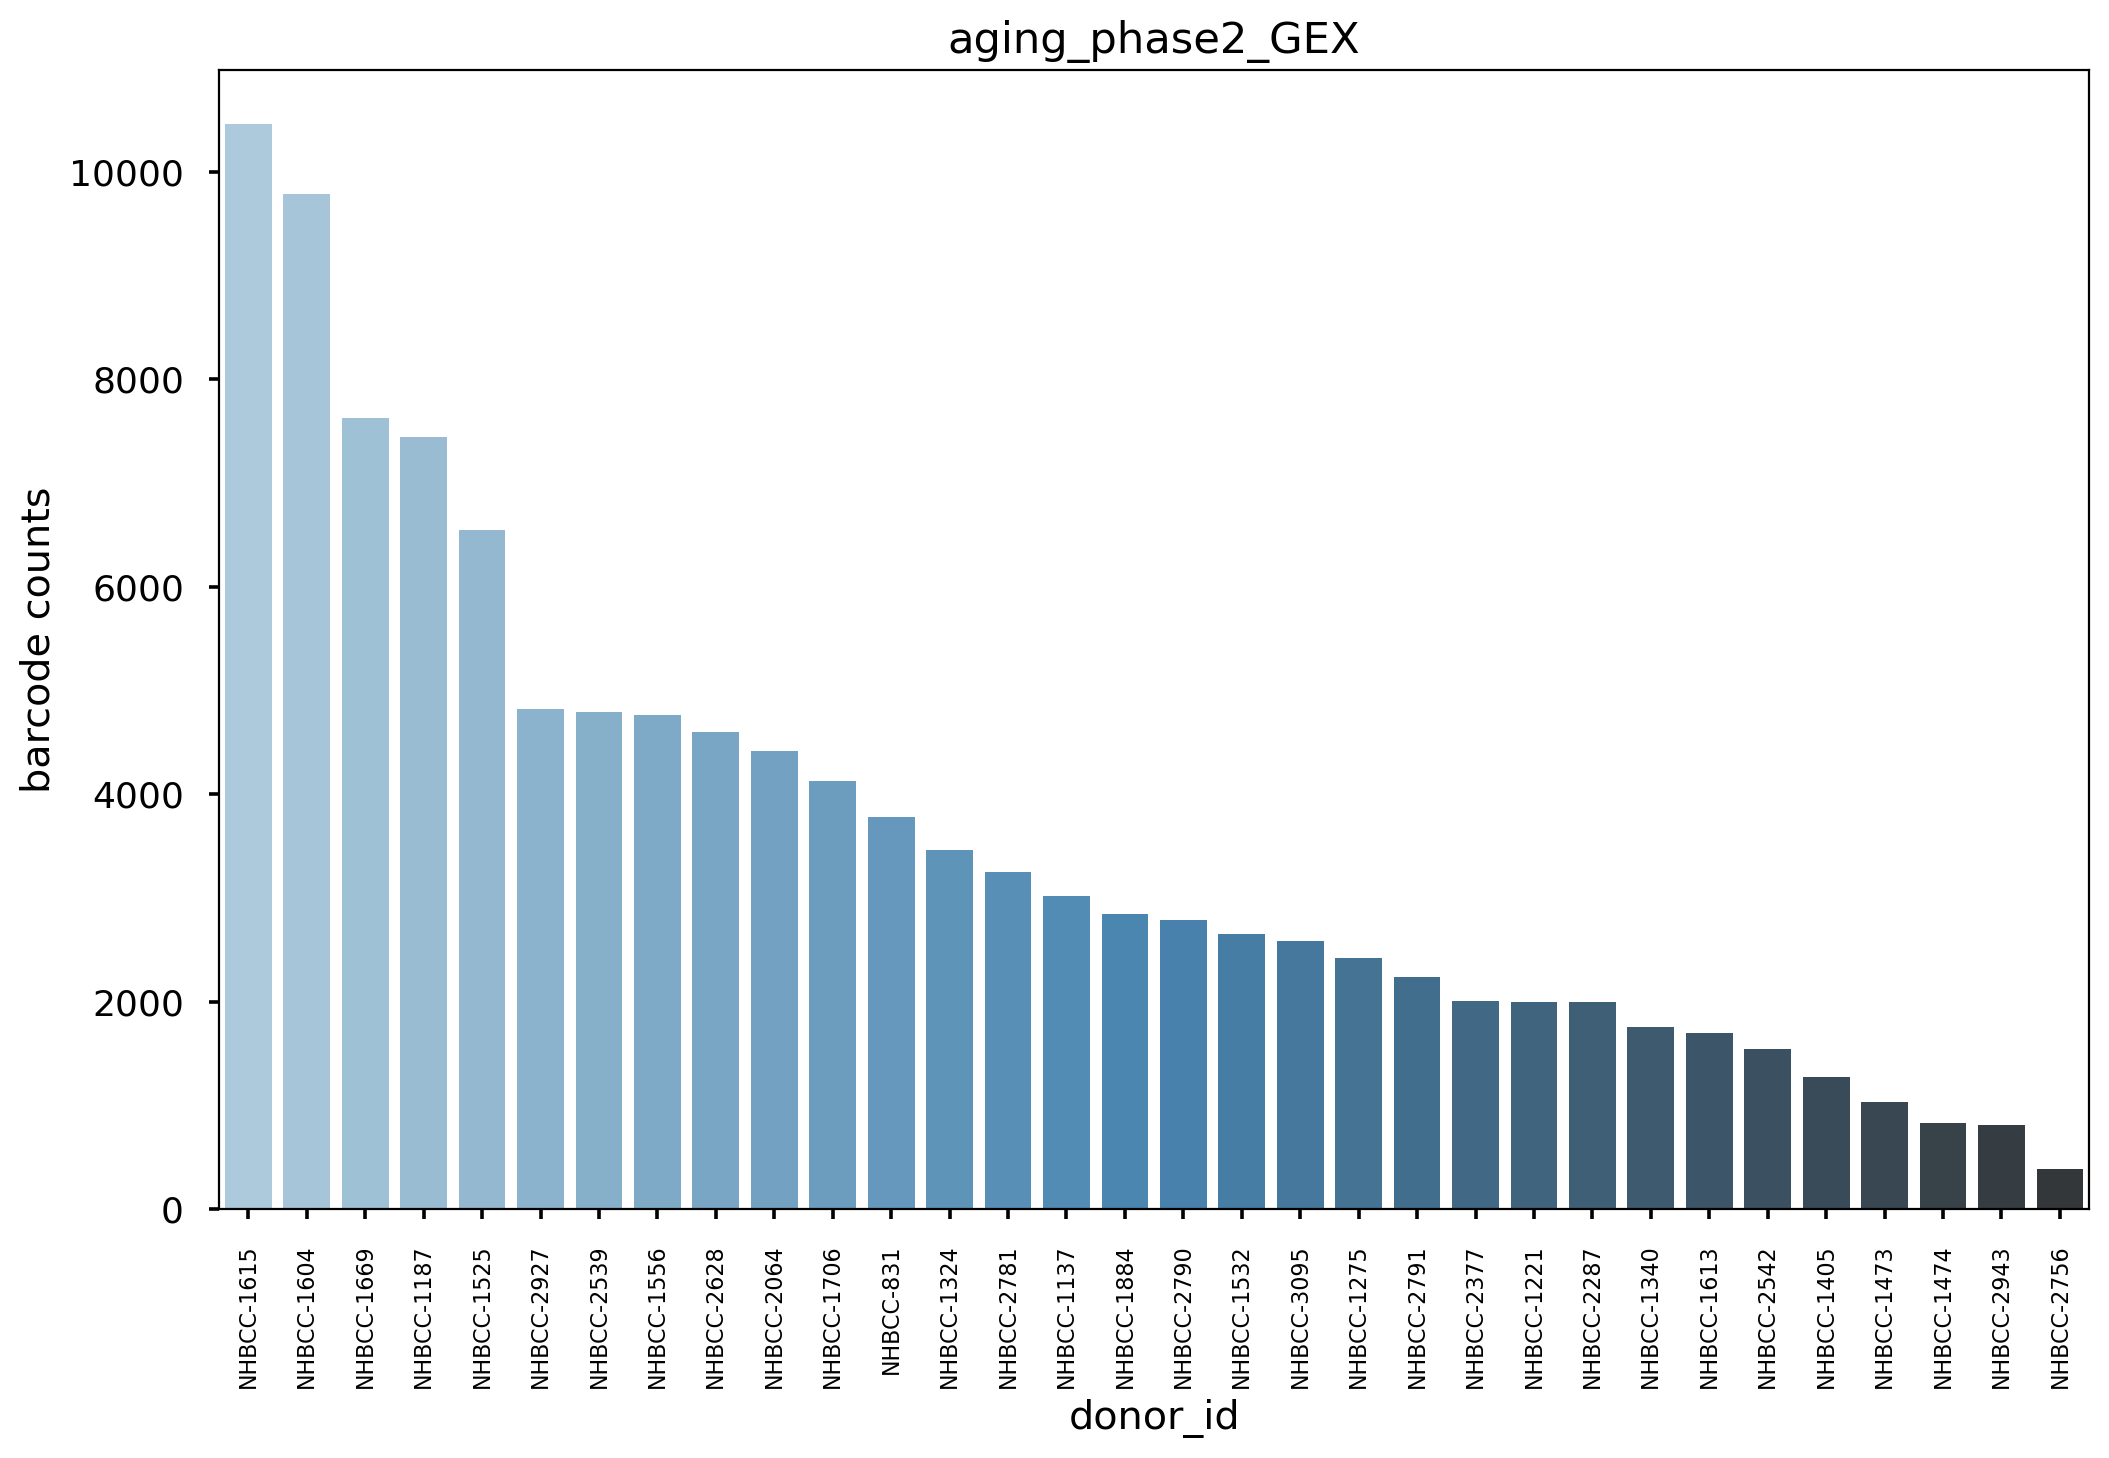

donor_id
NHBCC-1615    10459
NHBCC-1604     9785
NHBCC-1669     7626
NHBCC-1187     7445
NHBCC-1525     6544
NHBCC-2927     4821
NHBCC-2539     4796
NHBCC-1556     4759
NHBCC-2628     4596
NHBCC-2064     4412
NHBCC-1706     4123
NHBCC-831      3776
NHBCC-1324     3460
NHBCC-2781     3253
NHBCC-1137     3016
NHBCC-1884     2844
NHBCC-2790     2792
NHBCC-1532     2654
NHBCC-3095     2585
NHBCC-1275     2419
NHBCC-2791     2239
NHBCC-2377     2011
NHBCC-1221     2000
NHBCC-2287     1995
NHBCC-1340     1756
NHBCC-1613     1697
NHBCC-2542     1540
NHBCC-1405     1270
NHBCC-1473     1032
NHBCC-1474      834
NHBCC-2943      816
NHBCC-2756      385
Name: count, dtype: int64


In [10]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'donor_id')

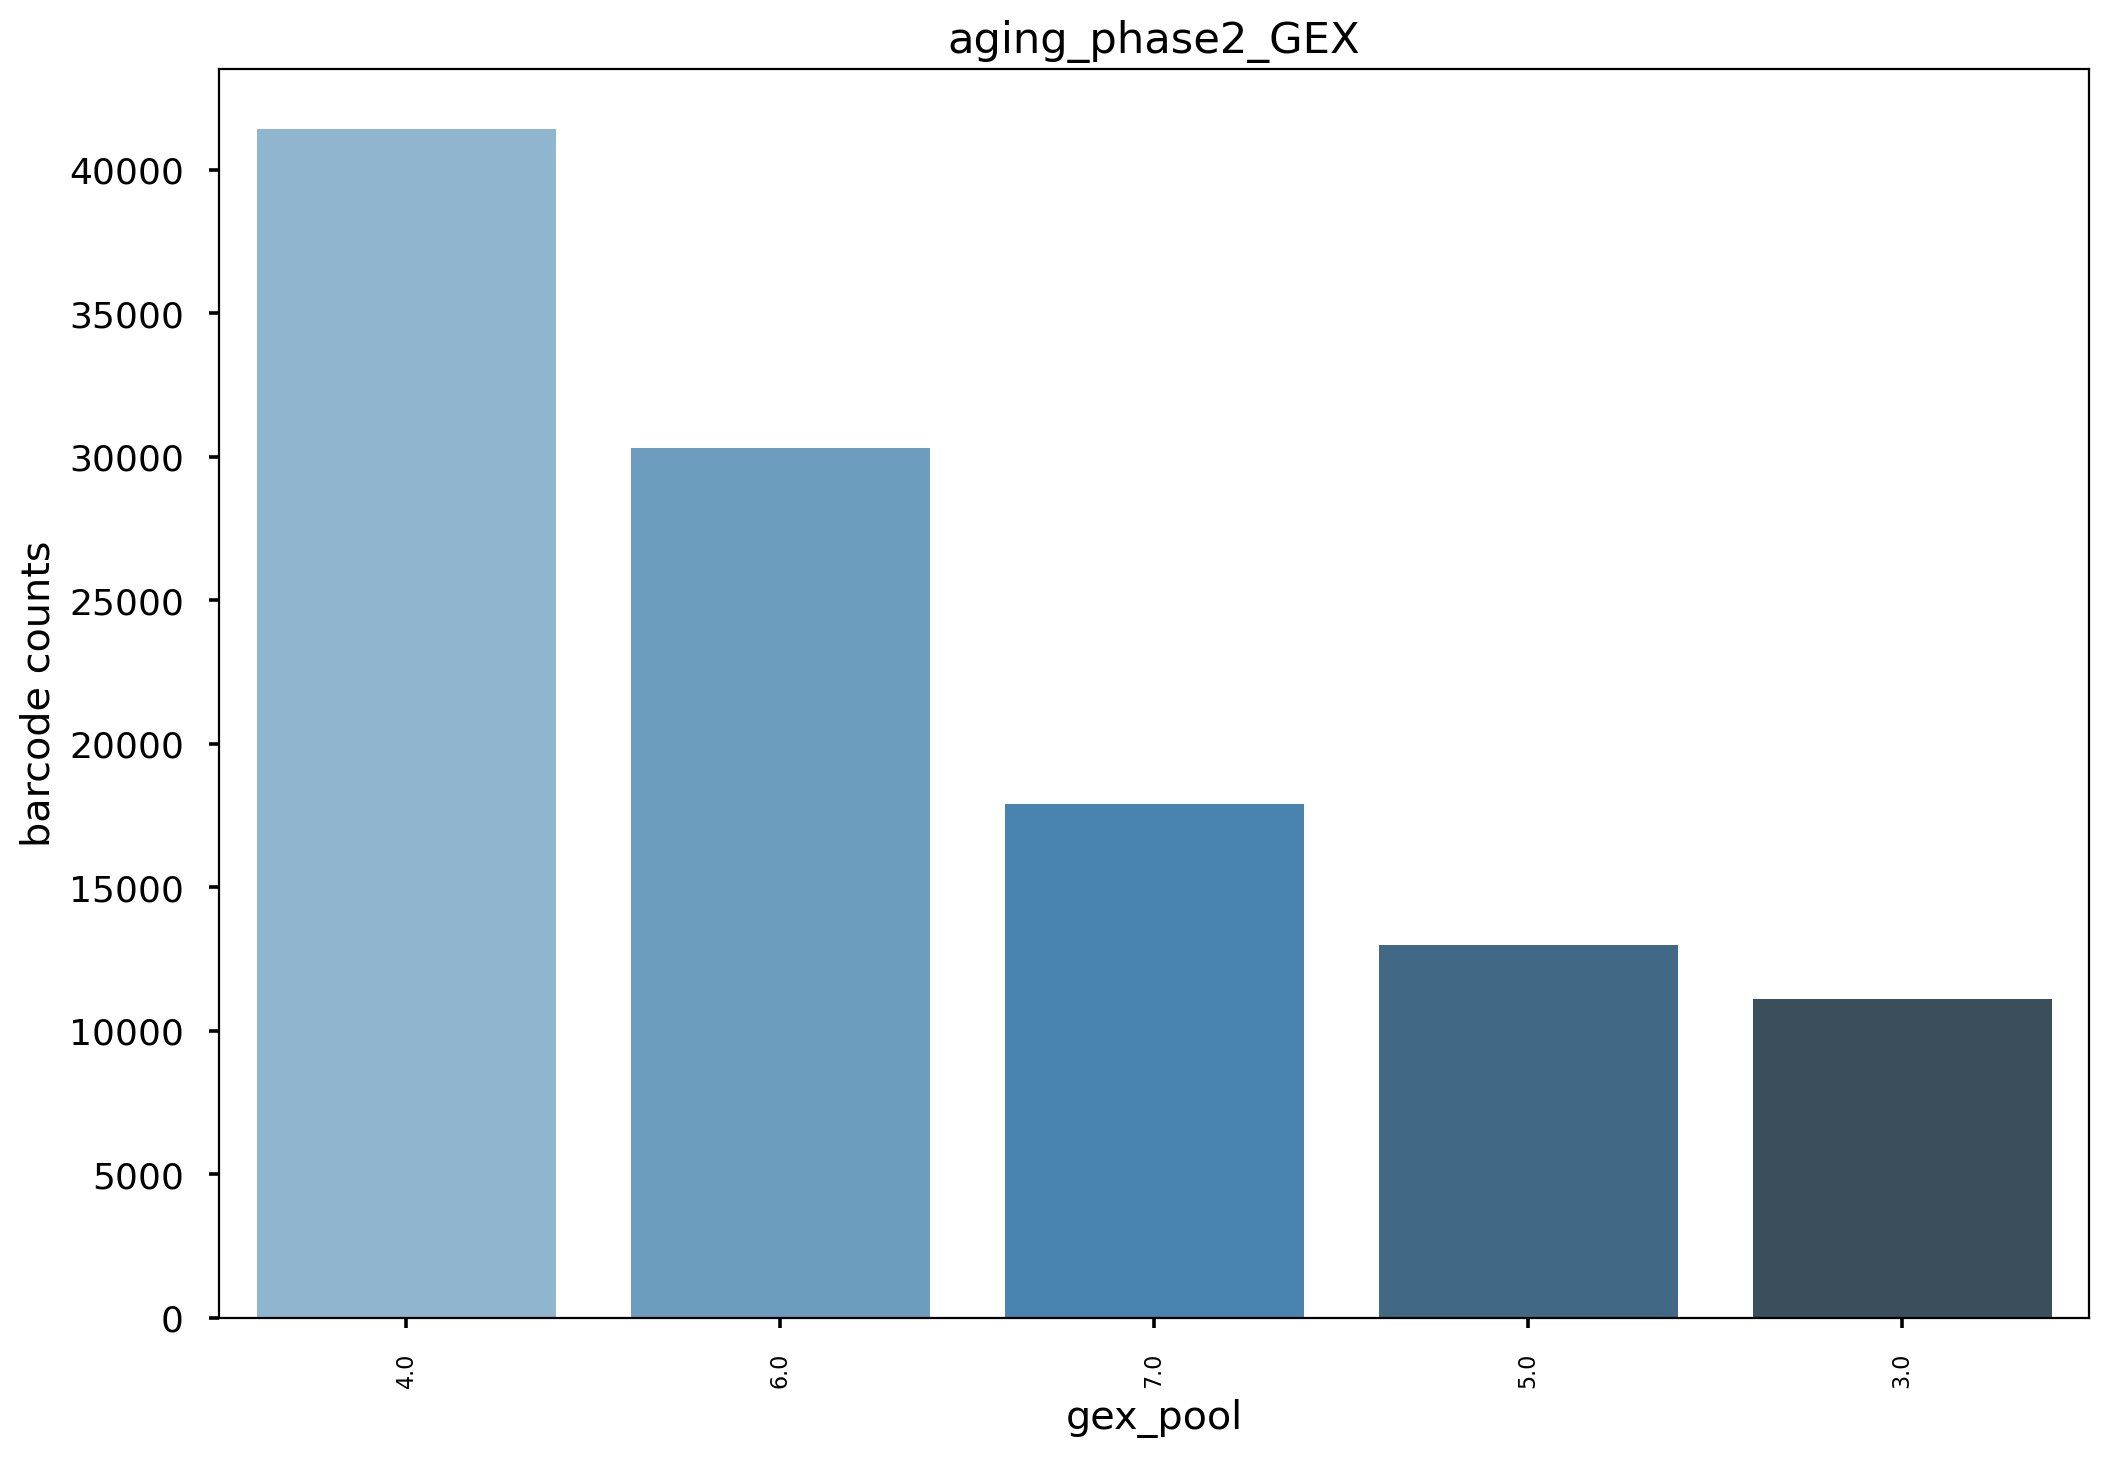

gex_pool
4.0    41431
6.0    30313
7.0    17915
5.0    12986
3.0    11095
Name: count, dtype: int64


In [11]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'gex_pool')

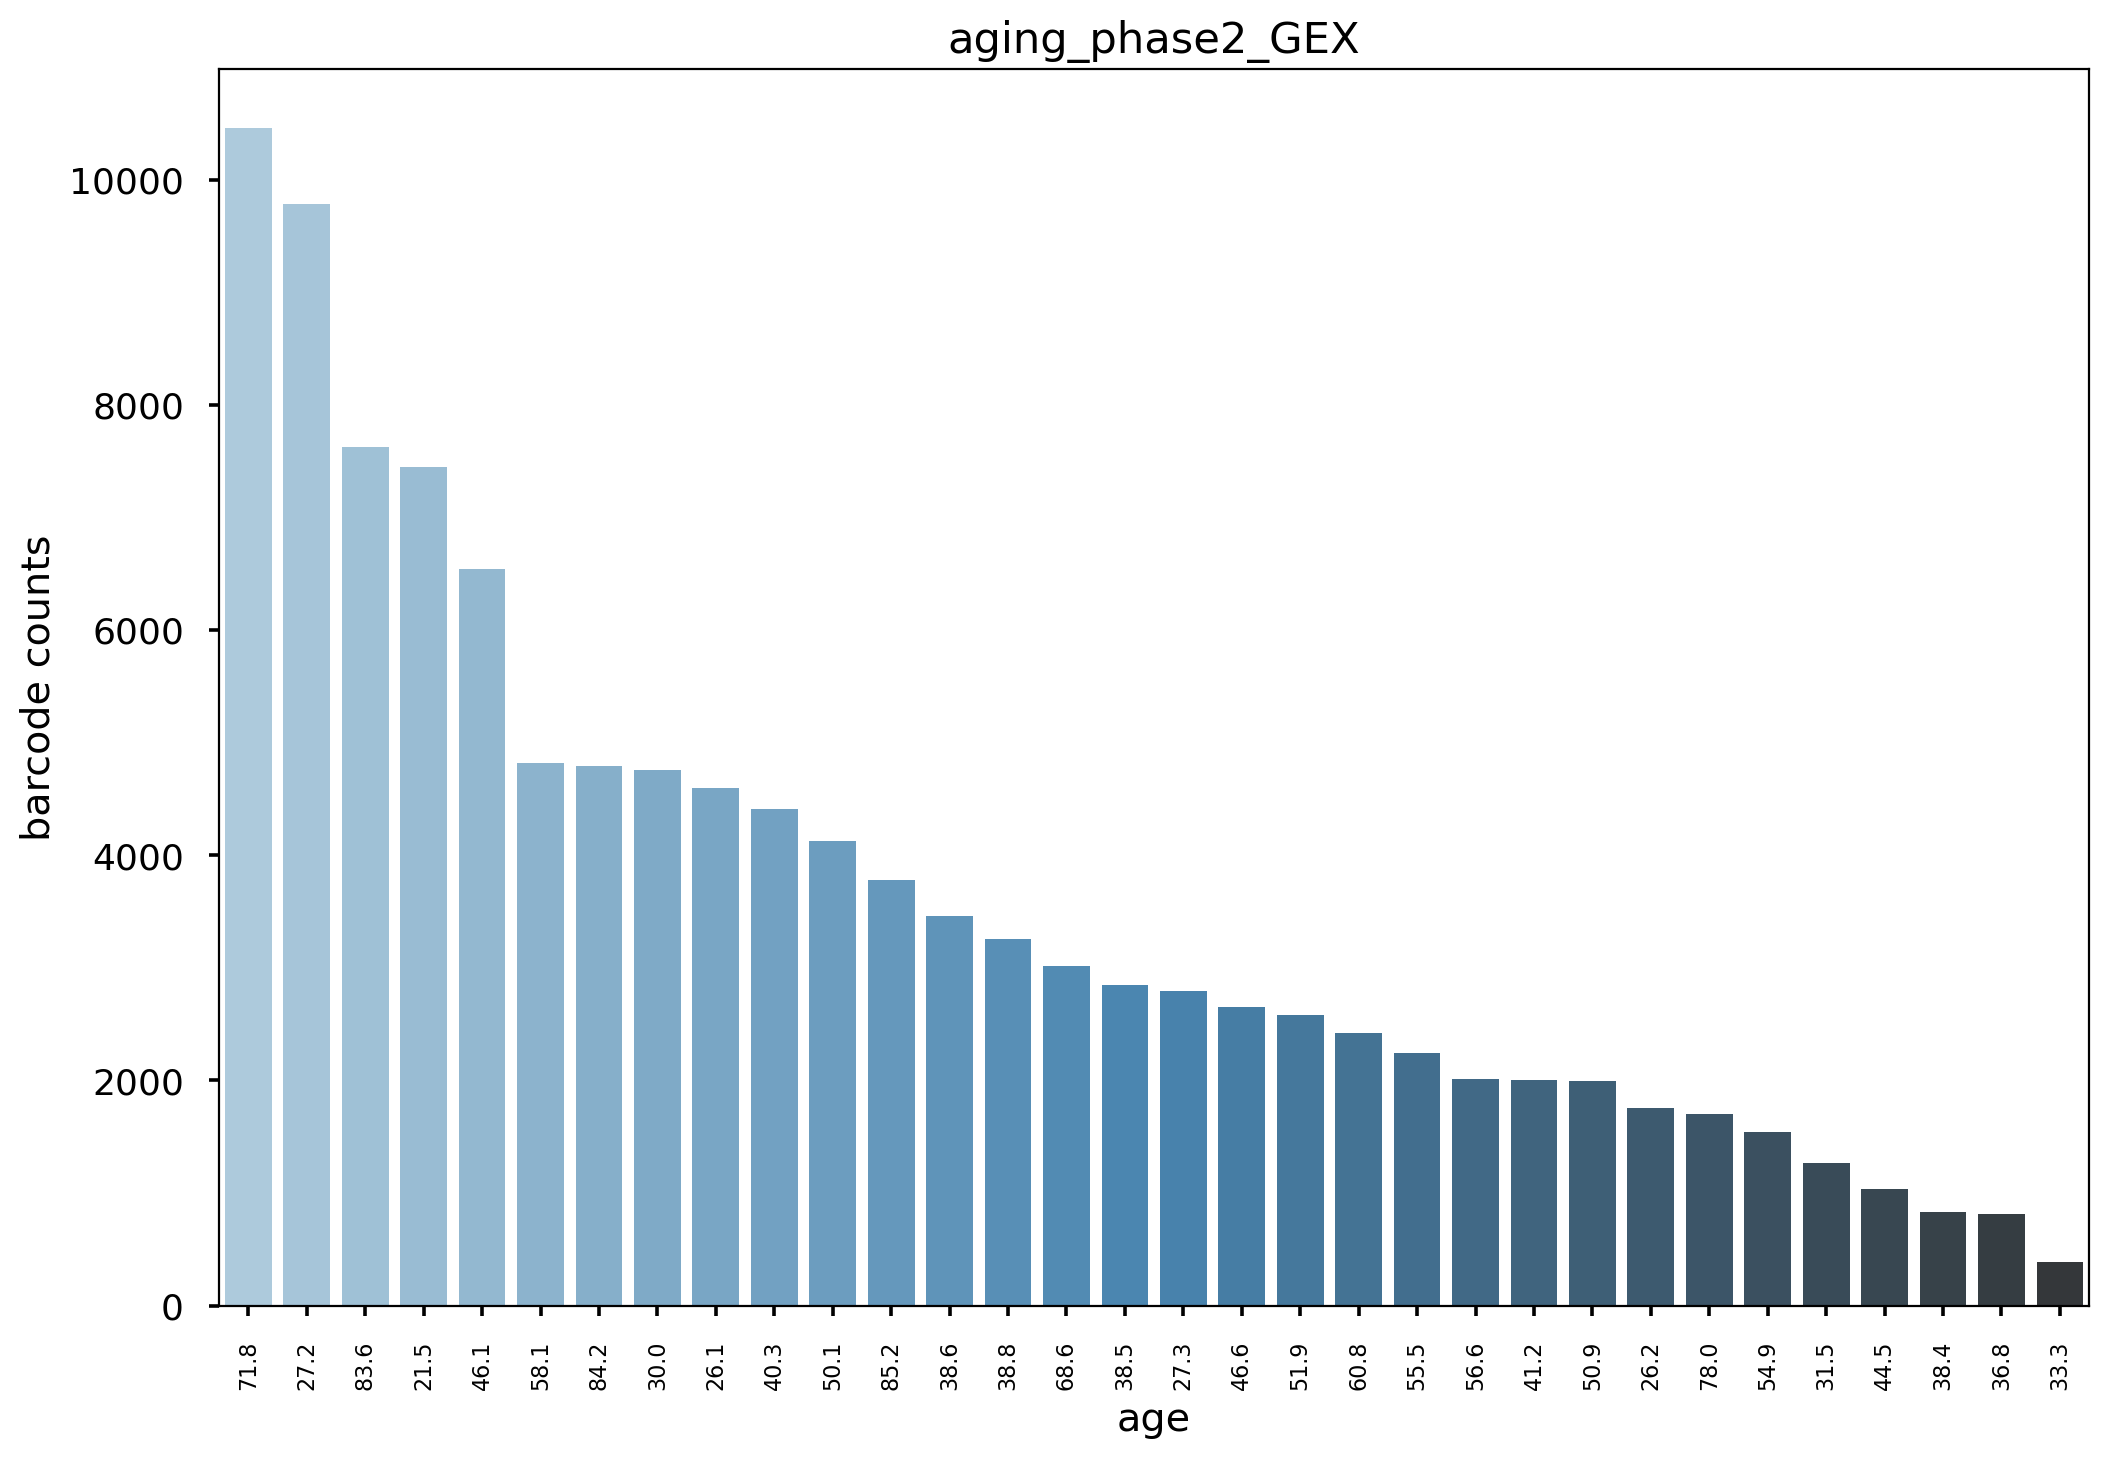

age
71.8    10459
27.2     9785
83.6     7626
21.5     7445
46.1     6544
58.1     4821
84.2     4796
30.0     4759
26.1     4596
40.3     4412
50.1     4123
85.2     3776
38.6     3460
38.8     3253
68.6     3016
38.5     2844
27.3     2792
46.6     2654
51.9     2585
60.8     2419
55.5     2239
56.6     2011
41.2     2000
50.9     1995
26.2     1756
78.0     1697
54.9     1540
31.5     1270
44.5     1032
38.4      834
36.8      816
33.3      385
Name: count, dtype: int64


In [12]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'age')

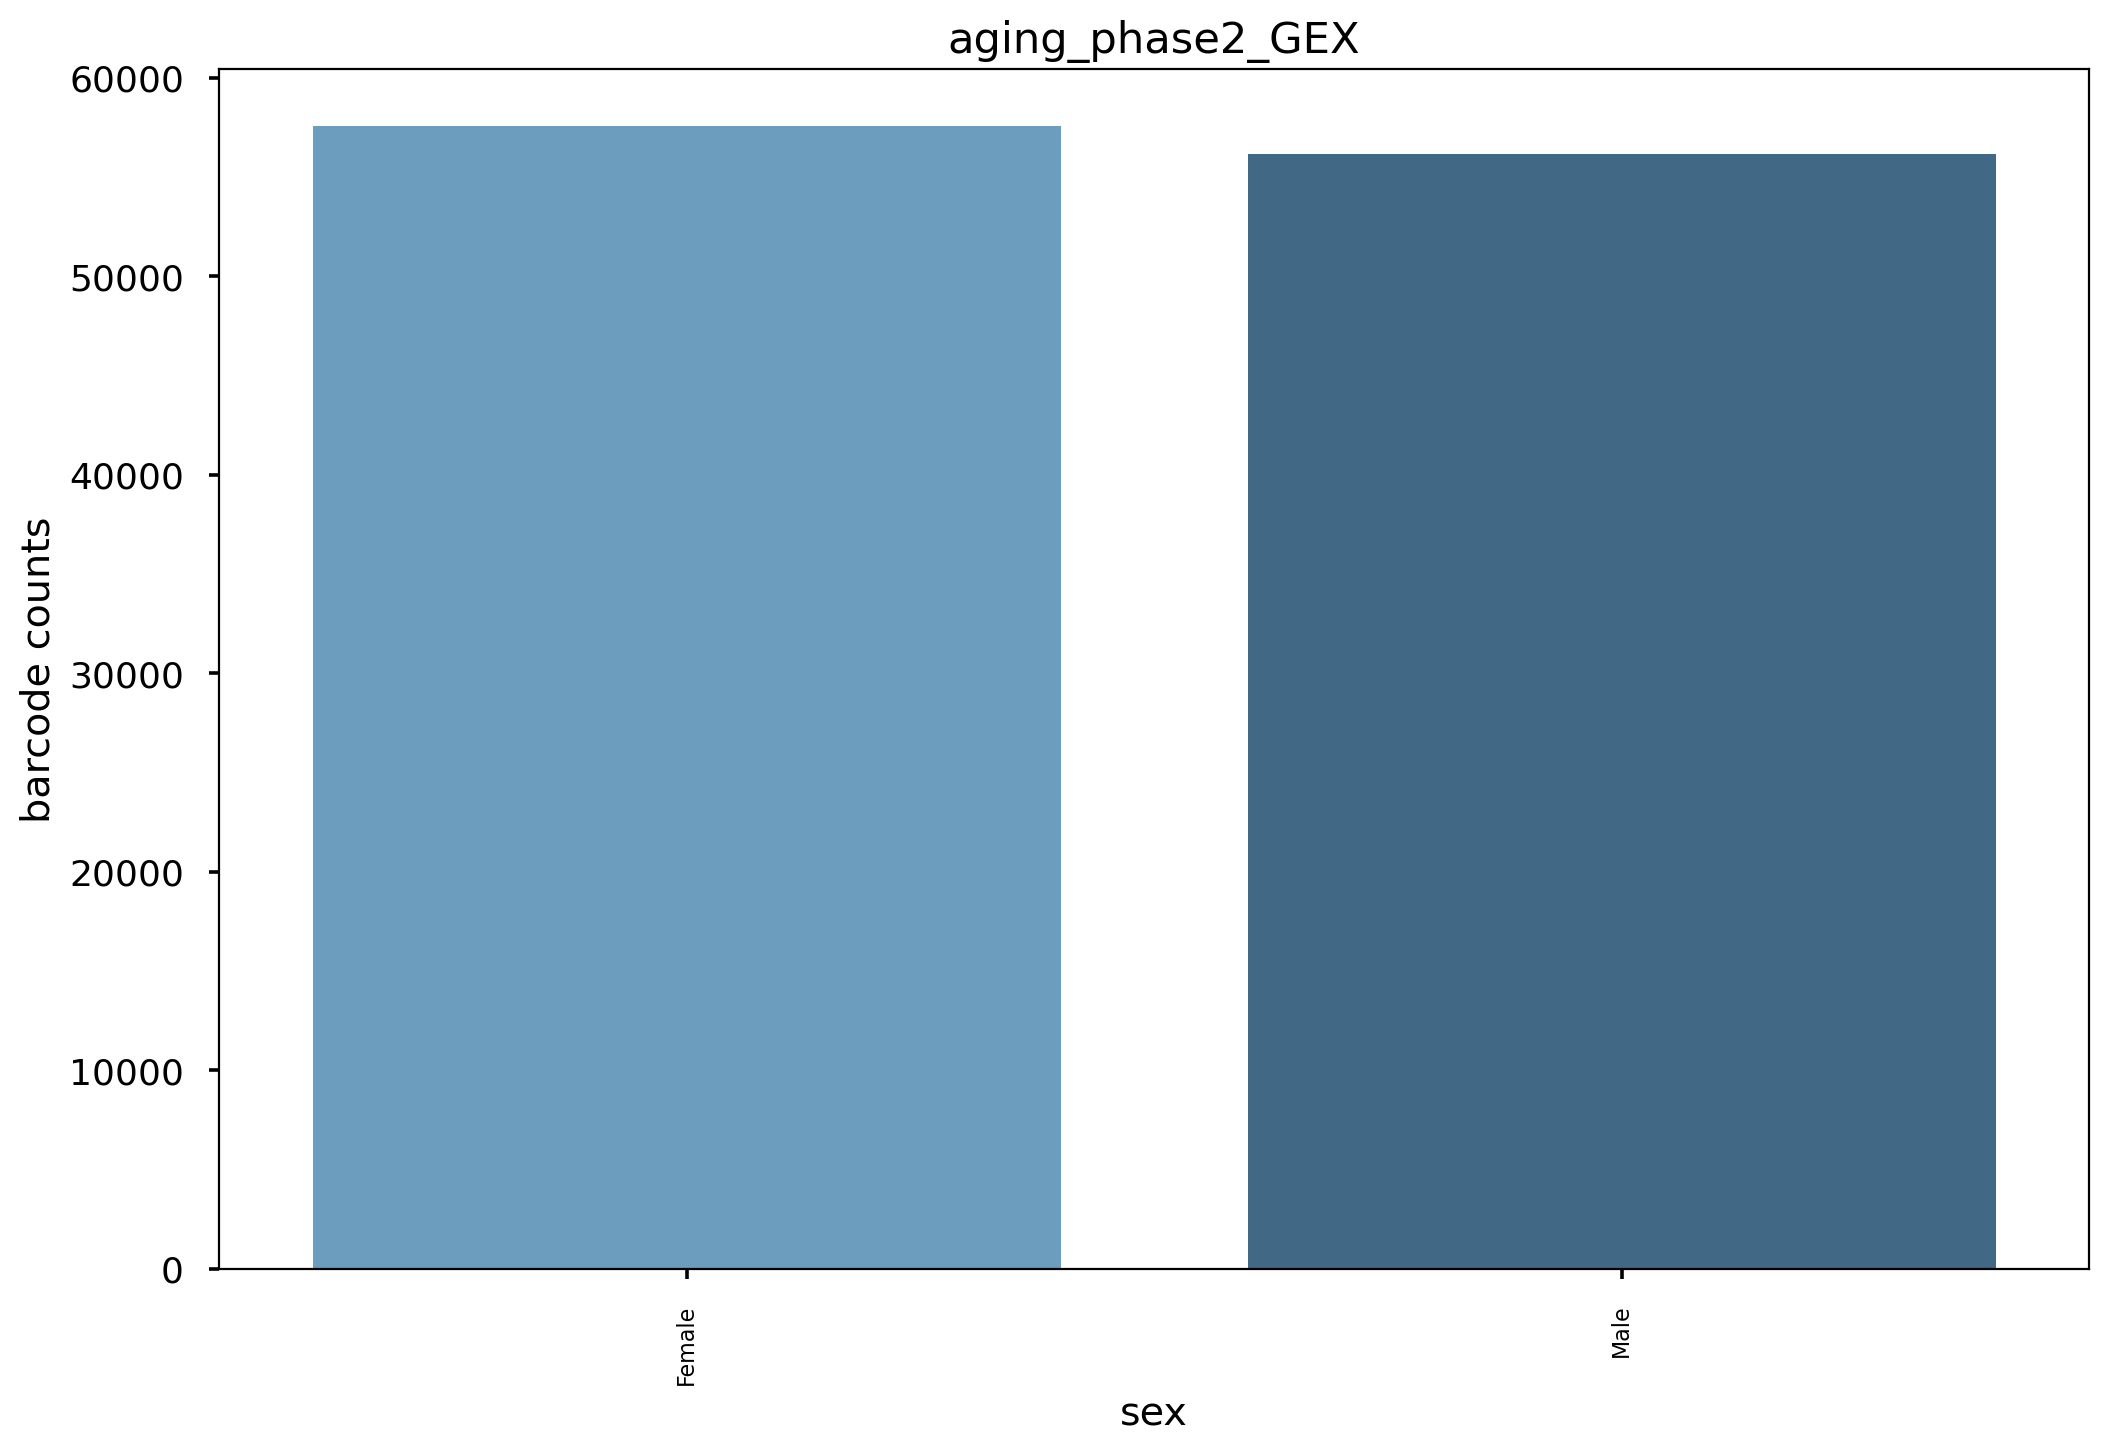

sex
Female    57565
Male      56175
Name: count, dtype: int64


In [13]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'sex')

In [14]:
!date

Wed Aug 30 15:03:16 EDT 2023
